# Hyperparameter tuning

Hyperparameter tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm in order to increase the generalizability of the model.
A hyperparameter is a parameter whose value is used to control the learning process. 
The aim is to find a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given independent data.

We implemented the gridsearchCV method for the hyperparameter tuning of the SVR, KNN, XGboost and Gradient Boosting models.
Gridsearch is an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. 
We chose as performance metric that guides the grid search algorithm the R-SQUARED, which was measured by cross-validation on the training set.
For the hyperparameter tuning of the random forest we implemented the randomized search CV since we had several hyperparameters with a wide grid of values.
In fact randomized search instead of using all the points in the grid, it tests only a randomly selected subset of these points.

In [1]:
%run setup.ipynb

Training and testing sets splitted randomly according to the paper's proportions

In [2]:
X_train = pd.read_csv(DATA_PATH+'/X_train.csv')
X_test = pd.read_csv(DATA_PATH+'/X_test.csv')
Y_train = pd.read_csv(DATA_PATH+'/Y_train.csv')
Y_test = pd.read_csv(DATA_PATH+'/Y_test.csv')
X_train=X_train.drop('Unnamed: 0',axis=1)
X_test=X_test.drop('Unnamed: 0',axis=1)
Y_test=Y_test['reproduction_rate']
Y_train=Y_train['reproduction_rate']
feature_importances = pd.read_csv(DATA_PATH+'/feature_importances.csv')
feature_importances=feature_importances.drop('Unnamed: 0',axis=1)

## Random Forest without feature selection and with hyperparameter tuned

In [4]:
rf = RandomForestRegressor(n_estimators = 100, n_jobs = (-1), oob_score = True, bootstrap = True, random_state = 42)

-n_estimators: the number of trees in the forest.
-max_depth: the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
-min_samples_split: the minimum number of samples required to split an internal node
-min_samples_leaf: the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
-max_features: the number of features to consider when looking for the best split
-bootstrap: whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree


In [5]:
parameters_rf = {'n_estimators': [200, 400, 600, 800, 1000, 1200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [70, 80, 90, 100, 110],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [2, 4],
               'bootstrap': [True]}

In [6]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = parameters_rf, n_iter = 20, cv = 3,
                               random_state=42, n_jobs= (-1), error_score='raise')
start_time_rf = timer(None)
rf_random.fit(X_train, Y_train)
timer(start_time_rf)

/Users/giorgiasacco/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 Time taken: 0 hours 23 minutes and 57.06 seconds.


In [84]:
second_rf=start_time_rf.minute*60+start_time_rf.second+start_time_rf.microsecond*0.000001

In [7]:
print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

0.8591071002506663
RandomForestRegressor(max_depth=80, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=1200, n_jobs=-1,
                      oob_score=True, random_state=42)
{'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}


In [8]:
rf_ht=RandomForestRegressor(random_state=42, max_features='sqrt', n_estimators= 1200, max_depth=80, bootstrap= True, min_samples_split= 5,
 min_samples_leaf= 2)

In [9]:
rf_ht.fit(X_train, Y_train)
Y_pred_rf_ht=rf_ht.predict(X_test) 
pd.DataFrame(Y_pred_rf_ht).to_csv(RESULTS_PATH+'/Y_pred_rf_3.csv')

In [10]:
MSE_rf=mean_squared_error(Y_test, Y_pred_rf_ht)
print(MSE_rf)

0.008196764190267842


In [11]:
R2_rf=r2_score(Y_test, Y_pred_rf_ht)
print(R2_rf)

0.8998175171142139


In [12]:
RMSE_rf = np.sqrt(mean_squared_error(Y_test, Y_pred_rf_ht))
print(RMSE_rf)

0.09053598284808004


In [13]:
MAE_rf=mean_absolute_error(Y_test, Y_pred_rf_ht)
print(MAE_rf)

0.0463139798479322


In [14]:
RAE_rf=RAE(Y_test, Y_pred_rf_ht)
print(RAE_rf)

0.08702010669102737


In [15]:
RRSE_rf=RRSE(Y_test, Y_pred_rf_ht)
print(RRSE_rf)

0.3165161652835109


## XGboost without feature selection and with hyperparameter tuned

-learning_rate: step size shrinkage used to prevent overfitting. Range is between 0 and 1
-max_depth: determines how deeply each tree is allowed to grow during any boosting round.
-subsample: percentage of samples used per tree. Low value can lead to underfitting.
-colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
-n_estimators: number of trees you want to build.
-min_child_weight: minimum sum of instance weight (hessian) needed in a child. In linear regression task, this it simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
The objective parameter will be reg:linear since we are dealing with a regression problem

In [16]:
parameters_xgb = {
        'min_child_weight': [3, 5],
        'learning_rate': [0.1, 0.5],
        'subsample': [0.5, 0.8],
        'colsample_bytree': [0.5, 0.7],
        'max_depth': [4, 5],
        'n_estimators': [100, 500]
        }
xgboost = xgb.XGBRegressor(n_estimators=100)

In [23]:
grid_xgb = GridSearchCV(estimator=xgboost, param_grid=parameters_xgb, cv=3, scoring='r2',verbose=3)
start_time_xgb = timer(None)
grid_xgb.fit(X_train, Y_train)
timer(start_time_xgb)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.5;, score=0.526 total time=   1.0s
[CV 2/3] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.5;, score=0.533 total time=   0.9s
[CV 3/3] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.5;, score=0.523 total time=   0.9s
[CV 1/3] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.8;, score=0.520 total time=   0.9s
[CV 2/3] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.8;, score=0.533 total time=   0.9s
[CV 3/3] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.8;, score=0.529 total time=   1.0s
[CV 1/3] END colsample_byt

In [85]:
second_xgboost=start_time_xgb.minute*60+start_time_xgb.second+start_time_xgb.microsecond*0.000001

In [24]:
print(grid_xgb.best_score_)
print(grid_xgb.best_estimator_)
print(grid_xgb.best_params_)

0.8591811592205385
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)
{'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.8}


In [25]:
xgb_ht = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.5, max_depth= 5,
                          min_child_weight= 5, n_estimators= 500, subsample= 0.8)
xgb_ht.fit(X_train, Y_train)
Y_pred_xgb_ht=xgb_ht.predict(X_test) 
pd.DataFrame(Y_pred_xgb_ht).to_csv(RESULTS_PATH+'/Y_pred_xgboost_3.csv')

In [26]:
MSE_xgboost=mean_squared_error(Y_test, Y_pred_xgb_ht)
print(MSE_xgboost)

0.009665290288932685


In [27]:
R2_xgboost=r2_score(Y_test, Y_pred_xgb_ht)
print(R2_xgboost)

0.8818688989361406


In [28]:
RMSE_xgboost = np.sqrt(mean_squared_error(Y_test, Y_pred_xgb_ht))
print(RMSE_xgboost)

0.09831220823952987


In [29]:
MAE_xgboost=mean_absolute_error(Y_test, Y_pred_xgb_ht)
print(MAE_xgboost)

0.0631993207061933


In [30]:
RAE_xgboost=RAE(Y_test, Y_pred_xgb_ht)
print(RAE_xgboost)

0.09449434999109661


In [31]:
RRSE_xgboost=RRSE(Y_test, Y_pred_xgb_ht)
print(RRSE_xgboost)

0.34370205274896287


## Gradient boosting without feature selection and with hyperparameter tuned

-learning_rate: step size shrinkage used to prevent overfitting.
-n_estimators: the number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
-subsample: the fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
-max_depth:maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. 


In [32]:
gbr_params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
gbr = GradientBoostingRegressor(**gbr_params)

In [33]:
parameters_gbr = {
    "n_estimators":[500,1500],
    "max_depth":[4,10],
    "learning_rate":[0.01,0.02],
    "subsample":[0.1,0.5]
}

grid_gbr = GridSearchCV(estimator=gbr, param_grid=parameters_gbr, cv=3, scoring='r2',verbose=3)
start_time_gbr = timer(None)
grid_gbr.fit(X_train, Y_train)
timer(start_time_gbr)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.1;, score=0.462 total time=   6.3s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.1;, score=0.476 total time=   6.3s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.1;, score=0.462 total time=   6.2s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5;, score=0.464 total time=  26.7s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5;, score=0.479 total time=  26.5s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5;, score=0.469 total time=  26.6s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.1;, score=0.583 total time=  18.0s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.1;, score=0.595 total time=  18.1s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_e

In [82]:
second_gbr=start_time_gbr.minute*60+start_time_gbr.second+start_time_gbr.microsecond*0.000001

In [34]:
print(grid_gbr.best_score_)
print(grid_gbr.best_estimator_)
print(grid_gbr.best_params_)

0.9149448267559058
GradientBoostingRegressor(learning_rate=0.02, max_depth=10, min_samples_split=5,
                          n_estimators=1500, subsample=0.5)
{'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 1500, 'subsample': 0.5}


In [86]:
gbr_ht = GradientBoostingRegressor(learning_rate=0.02, max_depth=10, min_samples_split=5,
                                   n_estimators=1500, subsample=0.5)
gbr_ht.fit(X_train, Y_train)
Y_pred_gbr_ht=gbr_ht.predict(X_test) 
pd.DataFrame(Y_pred_gbr_ht).to_csv(RESULTS_PATH+'/Y_pred_gbr_3.csv')

In [87]:
MSE_gbr=mean_squared_error(Y_test, Y_pred_gbr_ht)
print(MSE_gbr)

0.005020645900888393


In [88]:
R2_gbr=r2_score(Y_test, Y_pred_gbr_ht)
print(R2_gbr)

0.9386366668156025


In [89]:
RMSE_gbr = np.sqrt(mean_squared_error(Y_test, Y_pred_gbr_ht))
print(RMSE_gbr)

0.07085651629094104


In [90]:
MAE_gbr=mean_absolute_error(Y_test, Y_pred_gbr_ht)
print(MAE_gbr)

0.03886967620591551


In [91]:
RAE_gbr=RAE(Y_test, Y_pred_gbr_ht)
print(RAE_gbr)

0.06810487292923866


In [92]:
RRSE_gbr=RRSE(Y_test, Y_pred_gbr_ht)
print(RRSE_gbr)

0.24771623520551342


## K-nearest neighbor without feature selection and with hyperparameter tuned

-n_neighbors: Number of neighbors to use by default for kneighbors queries.

-weights: weight function used in prediction. Possible values:

‘uniform’ : uniform weights. All points in each neighborhood are weighted equally. Used by default.

‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [93]:
knn = KNeighborsRegressor(n_neighbors=7)
parameters_knn = [{'n_neighbors': [2,3,4,5], 'weights': ['uniform','distance']}]

In [94]:
grid_knn = GridSearchCV(estimator=knn, param_grid=parameters_knn, cv=3, scoring='r2')
start_time_knn = timer(None)
grid_knn.fit(X_train, Y_train)
timer(start_time_knn)


 Time taken: 0 hours 5 minutes and 48.76 seconds.


In [95]:
second_knn=start_time_knn.minute*60+start_time_knn.second+start_time_knn.microsecond*0.000001

In [96]:
print(grid_knn.best_score_)
print(grid_knn.best_estimator_)
print(grid_knn.best_params_)

0.5956675454293353
KNeighborsRegressor(weights='distance')
{'n_neighbors': 5, 'weights': 'distance'}


In [97]:
knn_ht = KNeighborsRegressor(weights='distance', n_neighbors=5)
knn_ht.fit(X_train, Y_train)
Y_pred_knn_ht=knn_ht.predict(X_test) 
pd.DataFrame(Y_pred_knn_ht).to_csv(RESULTS_PATH+'/Y_pred_knn_3.csv')

In [98]:
MSE_knn=mean_squared_error(Y_test, Y_pred_knn_ht)
print(MSE_knn)

0.02940953629522519


In [99]:
R2_knn=r2_score(Y_test, Y_pred_knn_ht)
print(R2_knn)

0.6405507956330474


In [100]:
RMSE_knn = np.sqrt(mean_squared_error(Y_test, Y_pred_knn_ht))
print(RMSE_knn)

0.1714920881417717


In [101]:
MAE_knn=mean_absolute_error(Y_test, Y_pred_knn_ht)
print(MAE_knn)

0.08750196753714305


In [102]:
RAE_knn=RAE(Y_test, Y_pred_knn_ht)
print(RAE_knn)

0.16483236098298382


In [103]:
RRSE_knn=RRSE(Y_test, Y_pred_knn_ht)
print(RRSE_knn)

0.5995408279399512


## Support Vector Regression without feature selection and with hyperparameter tuned

-kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used. If a callable is given it is used to precompute the kernel matrix.


-gamma{‘scale’, ‘auto’} or float, default=’scale’
Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,

if ‘auto’, uses 1 / n_features.

-C: regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

-epsilon: epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

In [104]:
svr = SVR(kernel = 'rbf')
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_std = sc_X.fit_transform(X_train)
Y_train_std = sc_y.fit_transform(Y_train.values.reshape(-1,1))
X_test_std = sc_X.fit_transform(X_test)

In [105]:
parameters_svr = [{'kernel': ['rbf','linear'],
                   'gamma': [ 1e-7,  0.01],
                   'C': [0.5, 1.5],
                   'epsilon': [0.1,1]}]
grid_svr = GridSearchCV(estimator=svr, param_grid=parameters_svr, cv=3, scoring='r2',verbose=3)

In [106]:
start_time_svr = timer(None)
grid_svr.fit(X_train_std, np.ravel(Y_train_std))
timer(start_time_svr)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END C=0.5, epsilon=0.1, gamma=1e-07, kernel=rbf;, score=-0.003 total time= 3.3min
[CV 2/3] END C=0.5, epsilon=0.1, gamma=1e-07, kernel=rbf;, score=-0.003 total time= 3.2min
[CV 3/3] END C=0.5, epsilon=0.1, gamma=1e-07, kernel=rbf;, score=-0.003 total time= 3.2min
[CV 1/3] END C=0.5, epsilon=0.1, gamma=1e-07, kernel=linear;, score=0.029 total time= 1.6min
[CV 2/3] END C=0.5, epsilon=0.1, gamma=1e-07, kernel=linear;, score=-0.094 total time= 1.4min
[CV 3/3] END C=0.5, epsilon=0.1, gamma=1e-07, kernel=linear;, score=0.030 total time= 1.5min
[CV 1/3] END C=0.5, epsilon=0.1, gamma=0.01, kernel=rbf;, score=0.103 total time= 1.8min
[CV 2/3] END C=0.5, epsilon=0.1, gamma=0.01, kernel=rbf;, score=0.106 total time= 1.9min
[CV 3/3] END C=0.5, epsilon=0.1, gamma=0.01, kernel=rbf;, score=0.108 total time= 1.8min
[CV 1/3] END C=0.5, epsilon=0.1, gamma=0.01, kernel=linear;, score=0.029 total time= 1.6min
[CV 2/3] END C=0.5, epsilon

In [107]:
second_svr=start_time_svr.minute*60+start_time_svr.second+start_time_svr.microsecond*0.000001

In [108]:
print(grid_svr.best_score_)
print(grid_svr.best_estimator_)
print(grid_svr.best_params_)

0.12363192944319441
SVR(C=1.5, gamma=0.01)
{'C': 1.5, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


In [109]:
svr_ht = SVR(C= 1.5, epsilon= 0.1, gamma= 0.01, kernel='rbf')
svr_ht.fit(X_train_std, np.ravel(Y_train_std))

SVR(C=1.5, gamma=0.01)

In [110]:
y_pred_svr_ht = svr_ht.predict(X_test_std)
Y_pred_svr_ht = sc_y.inverse_transform(y_pred_svr_ht) 
pd.DataFrame(Y_pred_svr_ht).to_csv(RESULTS_PATH+'/Y_pred_svr_3.csv')

In [111]:
MSE_svr=mean_squared_error(Y_test, Y_pred_svr_ht)
print(MSE_svr)

0.07104797353446171


In [112]:
R2_svr=r2_score(Y_test, Y_pred_svr_ht)
print(R2_svr)

0.13163753068106576


In [113]:
MAE_svr=mean_absolute_error(Y_test, Y_pred_svr_ht)
print(MAE_svr)

0.17063932753100927


In [114]:
RMSE_svr = np.sqrt(mean_squared_error(Y_test, Y_pred_svr_ht))
print(RMSE_knn)

0.1714920881417717


In [115]:
RAE_svr=RAE(Y_test, Y_pred_svr_ht)
print(RAE_svr)

0.25619711709599097


In [116]:
RRSE_svr=RRSE(Y_test, Y_pred_svr_ht)
print(RRSE_svr)

0.9318596832779441


Performance comparison graph of regression techniques without feature selection and with hyperparameter tuning:

In [117]:
rf_index=[MAE_rf,MSE_rf,RMSE_rf,R2_rf,RAE_rf,RRSE_rf]
xgboost_index=[MAE_xgboost,MSE_xgboost,RMSE_xgboost,R2_xgboost,RAE_xgboost,RRSE_xgboost]
gbr_index=[MAE_gbr,MSE_gbr,RMSE_gbr,R2_gbr,RAE_gbr,RRSE_gbr]
knn_index=[MAE_knn,MSE_knn,RMSE_knn,R2_knn,RAE_knn,RRSE_knn]
svr_index=[MAE_svr,MSE_svr,RMSE_svr,R2_svr,RAE_svr,RRSE_svr]

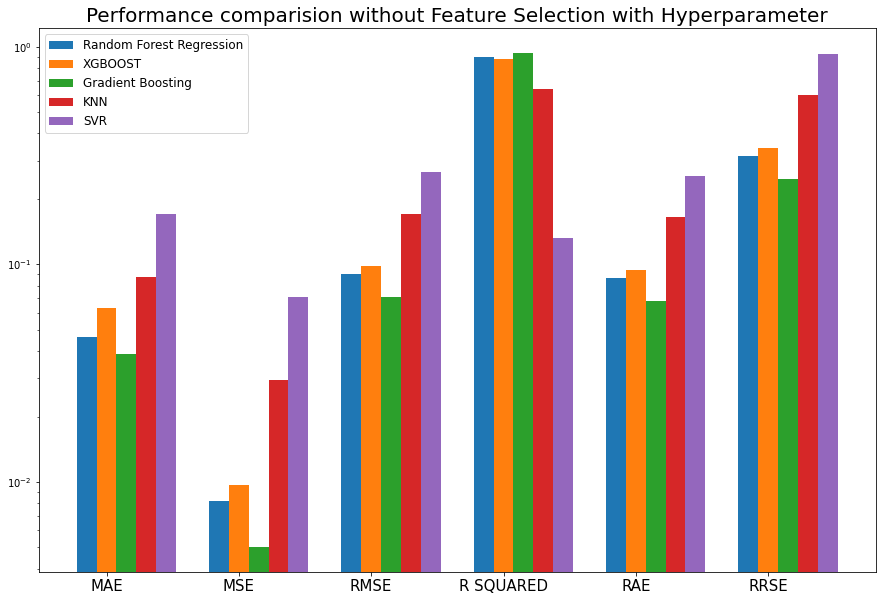

In [118]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=[15, 10])
X = np.arange(len(rf_index))
plt.bar(X, rf_index, color = 'tab:blue', width = 0.15)
plt.bar(X + 0.15, xgboost_index, color = 'tab:orange', width = 0.15)
plt.bar(X + 0.30, gbr_index, color = 'tab:green', width = 0.15)
plt.bar(X + 0.45, knn_index, color = 'tab:red', width = 0.15)
plt.bar(X + 0.60, svr_index, color = 'tab:purple', width = 0.15)
plt.legend(['Random Forest Regression', 'XGBOOST', 'Gradient Boosting','KNN', 'SVR'], fontsize=12)
plt.xticks([i + 0.15 for i in range(6)], ['MAE', 'MSE', 'RMSE', 'R SQUARED', 'RAE', 'RRSE'], fontsize=15)
plt.title("Performance comparision without Feature Selection with Hyperparameter", fontsize=20)
plt.semilogy()
plt.savefig(IMAGES_PATH+"/perf_comparison3.jpg")

In [119]:
Performance_Metrics=pd.DataFrame({'Performance Metrics':['MAE','MSE','RMSE','R-Squared','RAE','RRSE'],
                                  'Random Forest':rf_index,'XGBOOST':xgboost_index,
                                  'Gradient Boosting':gbr_index,'KNN':knn_index,'SVR':svr_index})

In [120]:
Performance_Metrics

Performance Metrics  Random Forest   XGBOOST  Gradient Boosting       KNN  \
0                 MAE       0.046314  0.063199           0.038870  0.087502   
1                 MSE       0.008197  0.009665           0.005021  0.029410   
2                RMSE       0.090536  0.098312           0.070857  0.171492   
3           R-Squared       0.899818  0.881869           0.938637  0.640551   
4                 RAE       0.087020  0.094494           0.068105  0.164832   
5                RRSE       0.316516  0.343702           0.247716  0.599541   

        SVR  
0  0.170639  
1  0.071048  
2  0.266548  
3  0.131638  
4  0.256197  
5  0.931860

Considering the experiment conducted without feature selection and with hyperparameter tuning we notice that the results are good after hyperparameter tuning is performed with the grid search or random search.
The XGBOOST, Gradient Boosting, KNN models improve thanks to hyperparameter tuning while Random Forest doesn't change consistly and SVR still performs badly.
Gradient Boosting becomes the best model followed by Random Forest with second-best scores for all metrics.

In [121]:
Performance_Metrics.to_csv(RESULTS_PATH+'/Performance_Metrics_3.csv')

In [122]:
#####Running time

In [123]:
second=[second_rf,second_xgboost,second_gbr,second_knn,second_svr]
ML_algorithms=['Random Forest Regression','XGBOOST','Gradient Boosting Regression',
               'KNeighbors Regressor','Support Vector Regression']

In [124]:
Running_time=pd.DataFrame({'ML algorithms':ML_algorithms,
                        'Running time including hyperparameter tuning with all features (in seconds)':second})

In [126]:
Running_time

ML algorithms  \
0      Random Forest Regression   
1                       XGBOOST   
2  Gradient Boosting Regression   
3          KNeighbors Regressor   
4     Support Vector Regression   

   Running time including hyperparameter tuning with all features (in seconds)  
0                                        2227.964821                            
1                                        3489.383683                            
2                                        2338.806956                            
3                                        1652.424955                            
4                                        2033.347355

We notice that the XGBOOST algorithm, followed by Gradient Boosting Regression and Random Forest Regression	require more time for hyperparameter tuning. Instead the KNN and SVR methods are able to perform hyperparameter tuning more rapidly. This depends in fact by the wideness of the grid and therefor also by the number of parameters taken into account.

In [125]:
Running_time.to_csv(RESULTS_PATH+'/Running_time.csv')